# **0. Install/import dependendcies**

In [ ]:
"""install libraries"""
!pip install gym gym[atari]
!pip install opencv-python
!pip install shimmy>=0.2.1

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

In [171]:
"""Import libraries"""
import gymnasium as gym
from gym import Env
import stable_baselines3
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from IPython.display import clear_output
from time import sleep
from matplotlib import animation

# **1. Starting and exploring Pitfall environment**

In [ ]:
env = gym.make("ALE/Pitfall-v5", render_mode="rgb_array").env

In [ ]:
env.reset()

In [ ]:
next_state

In [ ]:
# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print(f"Action space: {env.action_space}")
print(f"Action space: {env.unwrapped.get_action_meanings()}")

# Sample random action
action =env.action_space.sample()
print("Action: {}".format(action))
next_state, reward, done,_,info = env.step(action)

# Print output
print("Reward: {}".format(reward))
print(f"State done :{done}")
print(f"State info :{info}")

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

In [ ]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        #print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")
        # Pauze animation
        sleep(time_lag)

In [ ]:
def store_episode_as_gif(experience_buffer, path='./', filename='animation.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 300  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

In [ ]:
"""Simulation with random agent"""
epoch = 0
num_failed_dropoffs = 0
experience_buffer = []
cum_reward = 0

done = False

state = env.reset()

#while not done: ## full run - takes a long time
while epoch < 50:
    # Sample random action
    "Action selection without action mask"
    action = env.action_space.sample()

    "Action selection with action mask"
    #action = env.action_space.sample(env.action_mask(state))

    state, reward, done, _,info = env.step(action)
    cum_reward += reward

    # Store experience in dictionary
    experience_buffer.append({
        "frame": env.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )

    if reward == -10:
        num_failed_dropoffs += 1

    epoch += 1

# Run animation and print console output
run_animation(experience_buffer)
store_episode_as_gif(experience_buffer)

print("# epochs: {}".format(epoch))
print("# failed drop-offs: {}".format(num_failed_dropoffs))


# **2. Trying existing models**

In [170]:
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from gymnasium.wrappers import GrayScaleObservation
from stable_baselines3 import PPO, DQN
import torch
from stable_baselines3.common.callbacks import BaseCallback
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

## **Proximal Policy Optimization (PPO) - no modifications**

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = 'model'
            self.model.save(model_path)

        return True

In [ ]:
callback = TrainAndLoggingCallback(check_freq=20000, save_path='.')

In [ ]:
"""Adapt env to return gray pictures and stack 4 frames"""
env.reset()
env_PPO = GrayScaleObservation(env,keep_dim=True)
env_PPO = DummyVecEnv([lambda: env_PPO])
env_PPO = VecFrameStack(env_PPO, 4, channels_order='last')

In [ ]:
del model

In [ ]:
"""Create model"""
model = PPO('CnnPolicy', env_PPO, verbose=1, learning_rate=0.000001, n_steps=512) 

In [ ]:
"""Train Model"""
model.learn(total_timesteps=1000000,callback=callback,log_interval=10)

In [ ]:
"""Save Model"""
model.save('model')

In [ ]:
"""Load Model"""
model = PPO.load('model.zip',env=env_PPO)

In [ ]:
"""Test Model"""
import time
# Start the game 
state = env_PPO.reset()
done = False
# Loop through the game
while not done: 
    action, _ = model.predict(state)
    state, reward, done, info = env_PPO.step(action)
    frame = env_PPO.render()
    clear_output()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    time.sleep(0.01)
    

## **Proximal Policy Optimization (PPO) - costum wrapper**

In [ ]:
from gymnasium.wrappers import ResizeObservation

In [ ]:
class CustomEnv(gym.Wrapper):
    
    def __init__(self, env): 
        super().__init__(env)
        self.env = env
        self.lives = 3
        
    def step(self, action):
        before_lives = self.lives
        next_state, reward, done,truncated, info = self.env.step(action)
        lives = info['lives']
        # intensifies rewards
        if reward < 0 or reward > 0:
            reward *= 10
            
        # losing a life or all lifes is very penalised
        if before_lives > lives:
            reward -= 100000
            done = True
        if lives == 0:
            reward -= 100000 
        self.lives = lives
        return next_state, reward, done,truncated, info 

    

In [ ]:
env_test = CustomEnv(ResizeObservation(env,(130,130)))
env_test = GrayScaleObservation(env_test,keep_dim=True)

In [ ]:
env_test.reset()

In [ ]:
# Print dimensions of state and action space
print("State space: {}".format(env_test.observation_space))
print(f"Action space: {env_test.action_space}")
#print(f"Action space: {env_test.unwrapped.get_action_meanings()}")

# Sample random action
action = 3
print("Action: {}".format(action))
next_state, reward, done,truncated,info = env_test.step(action)

# Print output
print("Reward: {}".format(reward))
print(f"State done :{done}")
print(f"State truncated :{truncated}")
print(f"State info :{info}")

# Render and plot an environment frame
#frame = env.render()
plt.imshow(next_state)
plt.axis("off")
plt.show()

In [ ]:
#Action space: ['NOOP', 'FIRE', 'UP', 'RIGHT',
#               'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 
#               'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE',
#               'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE',
#               'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']

env_test.reset()
done = False
while not done:
    clear_output()
    action = 16
    next_state, reward, done,truncated,info = env_test.step(action)
    plt.imshow(next_state)
    plt.axis("off")
    plt.show()
    time.sleep(0.1)

In [ ]:
env_test = DummyVecEnv([lambda: env_test])
env_test = VecFrameStack(env_test, 4, channels_order='last')

In [ ]:
print("State space: {}".format(env_test.observation_space))

In [ ]:
next_state, reward, done,info = env_test.step([action])
plt.figure(figsize=(20,16))
for idx in range(next_state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(next_state[0][:,:,idx])
plt.show()

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = 'model_custom4'
            self.model.save(model_path)

        return True

In [ ]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path='.')

In [ ]:
"""Create model"""
model = PPO('CnnPolicy', env_test, verbose=1, learning_rate=0.000001, n_steps=512) 

In [ ]:
model.learn(total_timesteps=100000,callback=callback,log_interval=10)

In [ ]:
"""Save Model"""
model.save('model_custom2')

In [ ]:
"""Load Model"""
model = PPO.load('model_custom4.zip',env=env_test)

In [ ]:
"""Test Model"""

# Start the game 
state = env_test.reset()
done = False
# Loop through the game
while not done: 
    action, _ = model.predict(state)
    state, reward, done, info = env_test.step(action)
    frame = env_test.render()
    clear_output()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    time.sleep(0.01)

In [ ]:
epoch = 0
num_failed_dropoffs = 0
experience_buffer = []
cum_reward = 0

done = False
min_reward = 0
state = env_test.reset()


while not done:
    action, _ = model.predict(state)

    state, reward, done, _ = env_test.step(action)
    cum_reward += reward
    # Store experience in dictionary
    experience_buffer.append({
        "frame": env_test.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )

    if reward == -10:
        num_failed_dropoffs += 1

    epoch += 1

# Run animation and print console output
run_animation(experience_buffer)
store_episode_as_gif(experience_buffer,"animation2.gif")


In [ ]:
actions = [x['action'] for x in experience_buffer]
unique_actions = set()
for a in actions:
    unique_actions.add(a[0])

print(unique_actions)

# **Deep Q Network (DQN) - no modifications**

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = 'modelDQN'
            self.model.save(model_path)

        return True

In [ ]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path='.')

In [ ]:
"""Adapt env to return gray pictures and stack 4 frames"""
env.reset()
env_DQN = GrayScaleObservation(env,keep_dim=True)
env_DQN = DummyVecEnv([lambda: env_DQN])
env_DQN = VecFrameStack(env_PPO, 4, channels_order='last')

In [ ]:
"""Create model"""
model = DQN('CnnPolicy', env_DQN, verbose=1, learning_rate=0.00001) 

In [ ]:
"""Train Model"""
model.learn(total_timesteps=100000,callback=callback,log_interval=10,progress_bar=True)

In [ ]:
"""Save Model"""
model.save('model')

In [ ]:
"""Load Model"""
model = PPO.load('model.zip',env=env_DQN)

In [ ]:
"""Test Model"""
import time
# Start the game 
state = env_PPO.reset()
done = False
# Loop through the game
while not done: 
    action, _ = model.predict(state)
    state, reward, done, info = env_PPO.step(action)
    frame = env_PPO.render()
    clear_output()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    time.sleep(0.01)
    

## **Deep Q Network (DQN) - custom wrapper**

In [168]:
from gymnasium.wrappers import ResizeObservation

In [169]:
class CustomEnv(gym.Wrapper):
    
    def __init__(self, env): 
        super().__init__(env)
        self.env = env
        self.lives = 3
        
    def step(self, action):
        before_lives = self.lives
        next_state, reward, done,truncated, info = self.env.step(action)
        lives = info['lives']
        # intensifies rewards and truncates to the interval [-1,1]
        if reward > 0:
            if((reward *2)<1):
                reward *= 2
            else:
                reward = 1
        elif reward < 0:
            if((reward *2)>-1):
                reward *= 2
            else:
                reward = -1
        

        # losing a life or all lifes is very penalised
        if before_lives > lives:
            reward = -1
            done = True
        if lives == 0:
            reward = -1
        self.lives = lives
        return next_state, reward, done,truncated, info 

In [186]:
env_custom_DQN = CustomEnv(ResizeObservation(env,(130,130)))
env_custom_DQN = GrayScaleObservation(env_custom_DQN,keep_dim=True)

In [187]:
env_custom_DQN.reset()

(array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]], dtype=uint8),
 {'lives': 3, 'episode_frame_number': 0, 'frame_number': 4037651})

State space: Box(0, 255, (130, 130, 1), uint8)
Action space: Discrete(18)
Action: 3
Reward: 0.0
State done :False
State truncated :False
State info :{'lives': 3, 'episode_frame_number': 4, 'frame_number': 4037655}


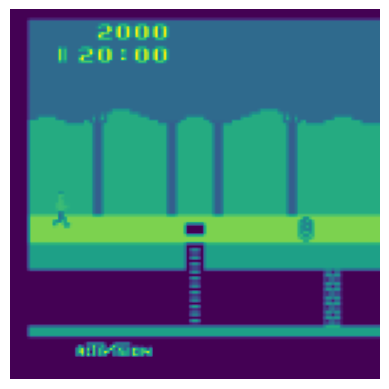

In [188]:
# Print dimensions of state and action space
print("State space: {}".format(env_custom_DQN.observation_space))
print(f"Action space: {env_custom_DQN.action_space}")
#print(f"Action space: {env_custom_DQN.unwrapped.get_action_meanings()}")

# Sample random action
action = 3
print("Action: {}".format(action))
next_state, reward, done,truncated,info = env_custom_DQN.step(action)

# Print output
print("Reward: {}".format(reward))
print(f"State done :{done}")
print(f"State truncated :{truncated}")
print(f"State info :{info}")

# Render and plot an environment frame
#frame = env.render()
plt.imshow(next_state)
plt.axis("off")
plt.show()

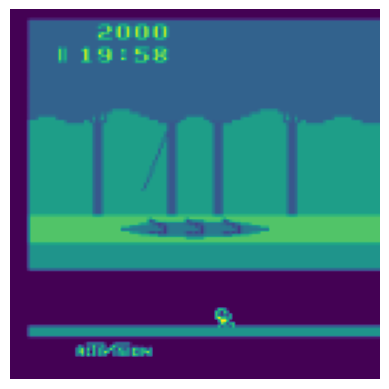

In [189]:
env_custom_DQN.reset()
done = False
while not done:
    clear_output()
    action = 4
    next_state, reward, done,truncated,info = env_custom_DQN.step(action)
    plt.imshow(next_state)
    plt.axis("off")
    plt.show()
    time.sleep(0.1)

In [190]:
env_custom_DQN = DummyVecEnv([lambda: env_custom_DQN])
env_custom_DQN = VecFrameStack(env_custom_DQN, 4, channels_order='last')

In [191]:
print("State space: {}".format(env_test.observation_space))

State space: Box(0, 255, (130, 130, 4), uint8)


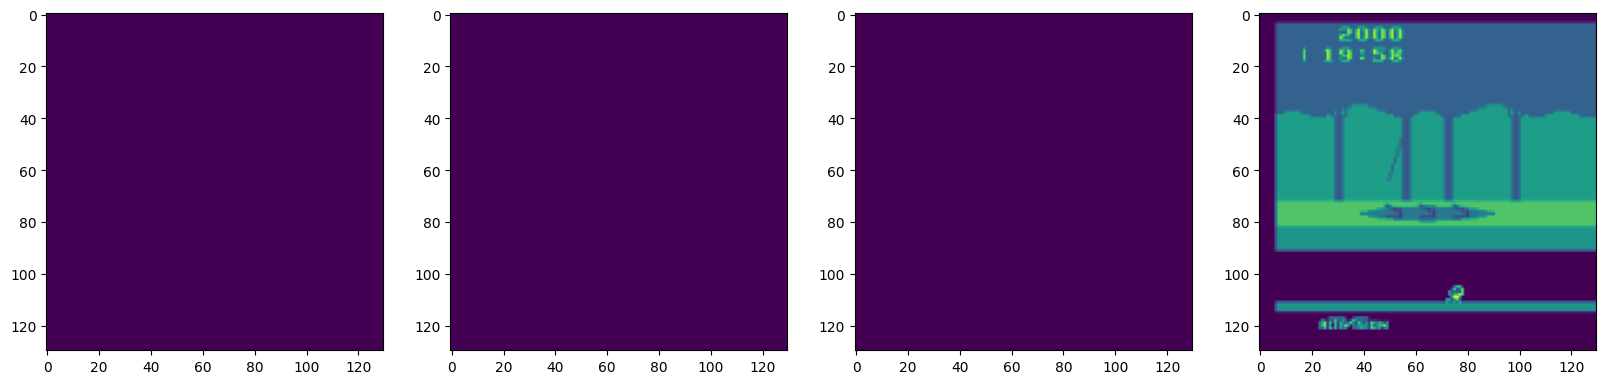

In [192]:
next_state, reward, done,info = env_custom_DQN.step([action])
plt.figure(figsize=(20,16))
for idx in range(next_state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(next_state[0][:,:,idx])
plt.show()

In [193]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = 'model_custom_DQN'
            self.model.save(model_path)

        return True

In [194]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path='.')

In [195]:
"""Create model"""
model = DQN('CnnPolicy', env_custom_DQN, verbose=1, learning_rate=0.00001) 

Using cuda device
Wrapping the env in a VecTransposeImage.


MemoryError: Unable to allocate 63.0 GiB for an array with shape (1000000, 1, 4, 130, 130) and data type uint8

In [ ]:
model.learn(total_timesteps=10000,callback=callback,log_interval=10)

In [ ]:
"""Save Model"""
model.save('model_custom_DQN')

In [ ]:
"""Load Model"""
model = DQN.load('model_custom_DQN',env=env_custom_DQN)

In [ ]:
"""Test Model"""

# Start the game 
state = env_test.reset()
done = False
# Loop through the game
while not done: 
    action, _ = model.predict(state)
    state, reward, done, info = env_test.step(action)
    frame = env_test.render()
    clear_output()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    time.sleep(0.01)

# **3. Making costum model**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras-rl2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy

In [ ]:
env_c = env
#env_c = GrayScaleObservation(env_c,keep_dim=True)
height, width, channels = env_c.observation_space.shape
actions = env_c.action_space.n

In [ ]:
env_c = CustomEnv(env_c)

In [ ]:
next_state, reward, done,_,info = env_c.step(action)

# Print output
print(f"Next state: {next_state.shape}")
print(f"State info :{info}")
print(f"State done :{done}")
print("Reward: {}".format(reward))

In [ ]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
model = build_model(height, width, channels, actions)

In [ ]:
model.summary()

In [ ]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000
                  )
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-4), metrics=['mae'])

In [ ]:
dqn.fit(env_c, nb_steps=10000, visualize=False, verbose=2)

In [ ]:
scores = dqn.test(env_c, nb_episodes=10, visualize=True)
print(np.mean(scores.history['episode_reward']))